# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)), 
                                transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=15)])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Load CIFAR-10 data
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split into training and validation sets
torch.manual_seed(42)
val_size = int(len(dataset) * 0.1)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(dataset)

50000

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Training data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


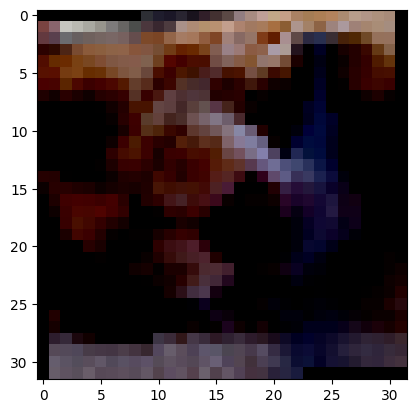

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


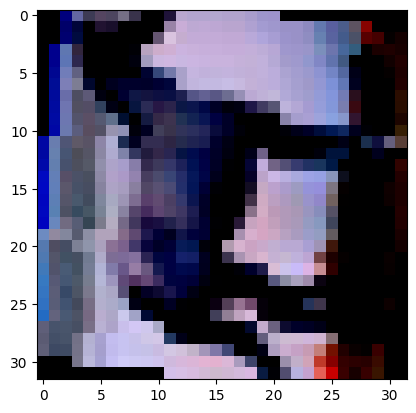

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


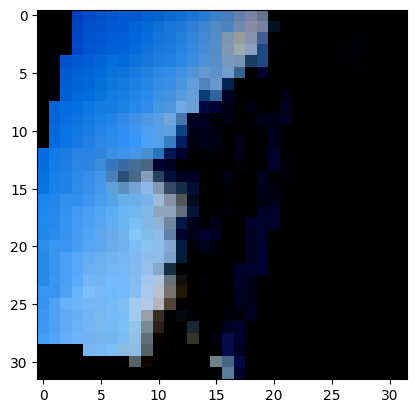

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


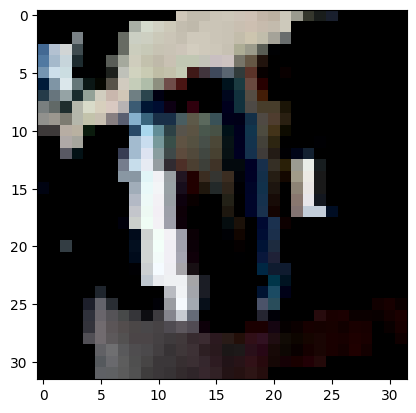

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


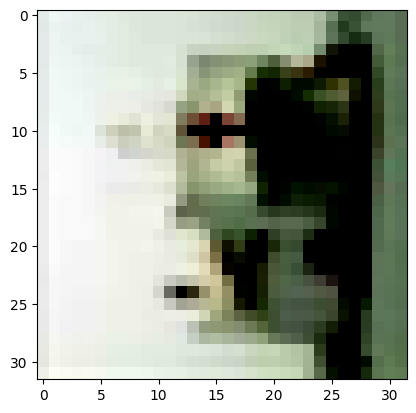

Validation data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


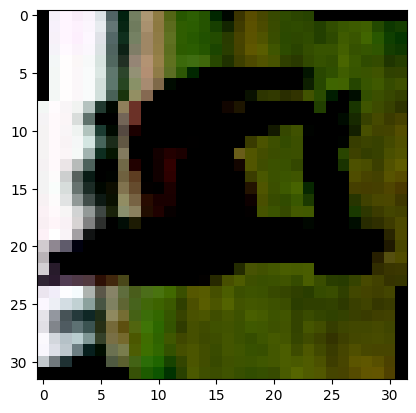

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


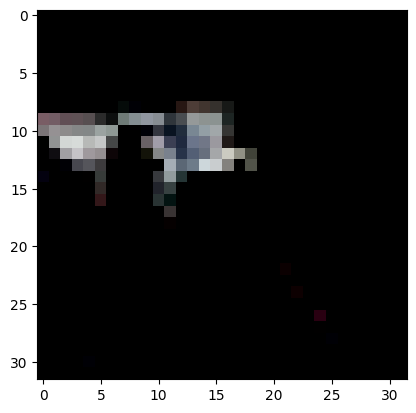

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


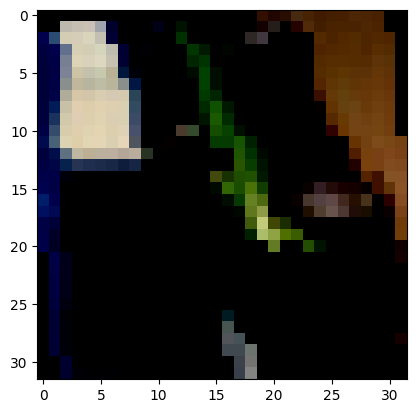

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


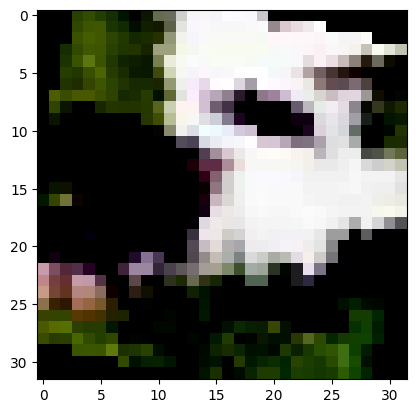

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


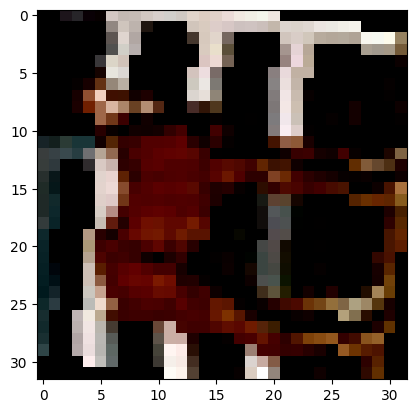

Test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


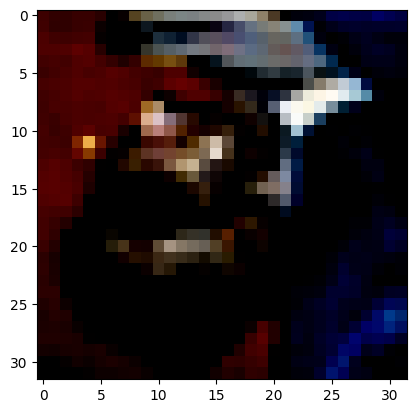

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


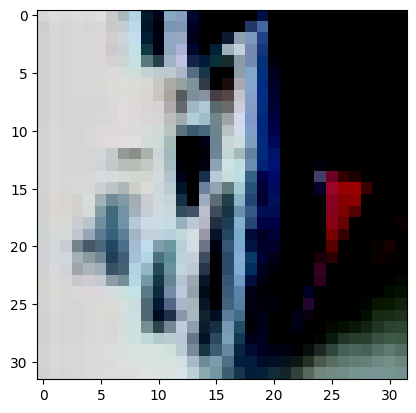

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


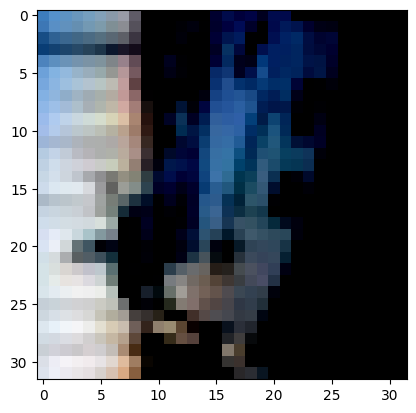

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


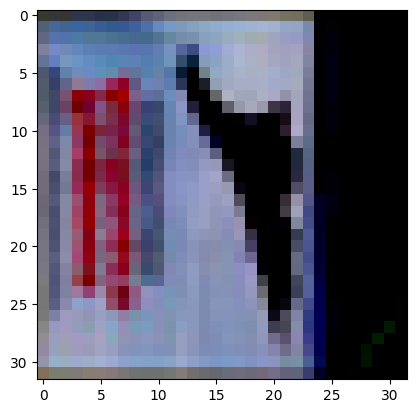

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


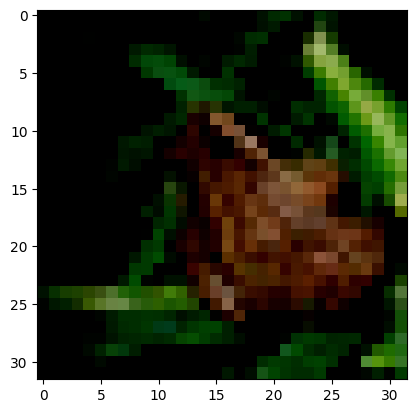

In [5]:
# Explore data
print("Training data")
show5(train_loader)
print("Validation data")
show5(val_loader)
print("Test data")
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
# Define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers
        # Convolutional layers
        # 3 is the number of channels in the input image
        # 16, 32, 64 are the number of filters applied by the convolutional layers
        # 3 is the size of the convolutional kernel
        # 1 is the padding added to the input image
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Pooling layer
        # 2 is the size of the pooling kernel
        # 2 is the stride of the pooling kernel
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # 64 * 4 * 4 is the number of pixels in the image
        # 500 is the number of nodes in the hidden layer
        # 10 is the number of classes
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

        # Dropout layer
        # 0.5 is the probability of dropping a node
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Define the forward pass
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        # Flatten the image
        # -1 is the number of samples in the batch
        x = x.view(-1, 64 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Create the network, define the criterion and optimizer
# Create the network
model = Net()
# Define the criterion
criterion = nn.CrossEntropyLoss()
# Define the optimizer
# Adam optimizer is used
# lr is the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Train the network
# Number of epochs
epochs = 30
train_losses, val_losses = [], []
# Iterate over the epochs
for e in range(epochs):
    # Keep track of the running loss
    running_loss = 0
    # Iterate over the training data
    for images, labels in train_loader:
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)
        # Calculate the loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
    else:
        val_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # Set the model to evaluation mode
            model.eval()
            # Iterate over the validation data
            for images, labels in val_loader:
                # Forward pass
                output = model(images)
                # Calculate the loss
                val_loss += criterion(output, labels)
                # Calculate the accuracy
                # Model outputs are log-softmax, take exponential to get the probabilities
                # Class with highest probability is our predicted class, compare with true label
                ps = torch.exp(output)
                # topk returns the k highest values. Here we just need the highest value
                top_p, top_class = ps.topk(1, dim=1)
                # Check if the predicted classes match the labels
                equals = top_class == labels.view(*top_class.shape)
                # Accuracy is number of correct predictions divided by all predictions, just take the mean
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # Set the model back to train mode
        model.train()

        # Print the metrics
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader)))

Epoch: 1/30..  Training Loss: 1.607..  Validation Loss: 1.371..  Validation Accuracy: 0.511
Epoch: 2/30..  Training Loss: 1.301..  Validation Loss: 1.196..  Validation Accuracy: 0.574
Epoch: 3/30..  Training Loss: 1.189..  Validation Loss: 1.068..  Validation Accuracy: 0.625
Epoch: 4/30..  Training Loss: 1.113..  Validation Loss: 0.997..  Validation Accuracy: 0.650
Epoch: 5/30..  Training Loss: 1.061..  Validation Loss: 0.966..  Validation Accuracy: 0.657
Epoch: 6/30..  Training Loss: 1.026..  Validation Loss: 0.937..  Validation Accuracy: 0.667
Epoch: 7/30..  Training Loss: 0.985..  Validation Loss: 0.882..  Validation Accuracy: 0.691
Epoch: 8/30..  Training Loss: 0.955..  Validation Loss: 0.870..  Validation Accuracy: 0.690
Epoch: 9/30..  Training Loss: 0.929..  Validation Loss: 0.868..  Validation Accuracy: 0.700
Epoch: 10/30..  Training Loss: 0.915..  Validation Loss: 0.815..  Validation Accuracy: 0.716
Epoch: 11/30..  Training Loss: 0.893..  Validation Loss: 0.797..  Validation Ac

Plot the training loss (and validation loss/accuracy, if recorded).

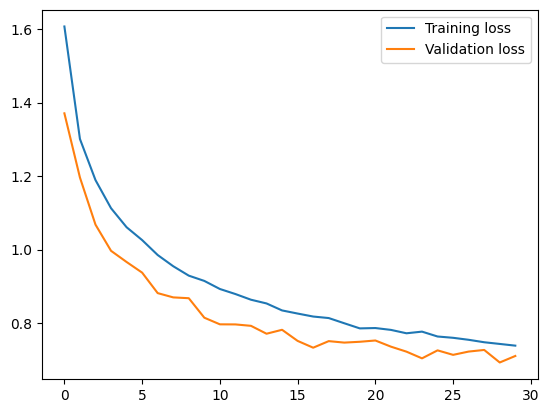

In [9]:
# Plot the training and test losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
# This is the test accuracy
test_accuracy, test_loss = 0, 0
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()
    # Iterate over the test data
    for images, labels in test_loader:
        # Forward pass
        output = model(images)
        # Calculate the loss
        test_loss += criterion(output, labels)
        # Calculate the accuracy
        # Model outputs are log-softmax, take exponential to get the probabilities
        # Class with highest probability is our predicted class, compare with true label
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print("Test Accuracy: {:.3f}".format(test_accuracy/len(test_loader)))

Test Accuracy: 0.768


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Save the model
torch.save(model.state_dict(), 'cifar10_model.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Based on my evaluation, I would recommend to buy a suitable model. The reason is that the accuracy of my model is only 76.8%. State-of-the-art models, however, can achieve an accuracy of 99.0%. Thus, buying a model is a better choice if we want to achieve a higher accuracy.